- 참고 : https://wikidocs.net/44249

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
# pip install konlpy

     --------------------------------------- 19.4/19.4 MB 13.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
# pip install tensorflow

     ------------------------------------ 438.0/438.0 MB 957.8 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 1.5/1.5 MB 30.7 MB/s eta 0:00:00
     --------------------------------------- 13.9/13.9 MB 11.1 MB/s eta 0:00:00



ERROR: Could not install packages due to an OSError: [WinError 5] 액세스가 거부되었습니다: 'c:\\programdata\\anaconda3\\lib\\site-packages\\importlib_metadata-3.10.0.dist-info\\direct_url.json'
Consider using the `--user` option or check the permissions.


     ---------------------------------------- 5.8/5.8 MB 16.1 MB/s eta 0:00:00
     ---------------------------------------- 3.4/3.4 MB 22.0 MB/s eta 0:00:00
     ---------------------------------------- 57.5/57.5 KB 3.0 MB/s eta 0:00:00
     ---------------------------------------- 1.4/1.4 MB 29.1 MB/s eta 0:00:00
     -------------------------------------- 462.5/462.5 KB 7.3 MB/s eta 0:00:00
     ---------------------------------------- 65.5/65.5 KB 3.5 MB/s eta 0:00:00
     ------------------------------------- 895.9/895.9 KB 28.6 MB/s eta 0:00:00
     ---------------------------------------- 42.6/42.6 KB ? eta 0:00:00
     -------------------------------------- 126.7/126.7 KB 7.3 MB/s eta 0:00:00
     -------------------------------------- 156.3/156.3 KB 9.7 MB/s eta 0:00:00
     ------------------------------------- 781.3/781.3 KB 24.9 MB/s eta 0:00:00
     ---------------------------------------- 97.8/97.8 KB 5.8 MB/s eta 0:00:00
  Created wheel for termcolor: filename=termcolor-

## 1. 데이터 로드하기

- 데이터 다운로드

In [8]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x1ea5a881e50>)

- pandas 이용하여 훈련 데이터는 train_data에 테스트 데이터는 test_data에 저장

In [10]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

- 훈련용 & 테스트용 리뷰 개수 확인

In [11]:
print("훈련용 리뷰 개수: ", len(train_data))
print("테스트용 리뷰 개수: ", len(test_data))

훈련용 리뷰 개수:  150000
테스트용 리뷰 개수:  50000


- 데이터 샘플 확인

In [12]:
# 훈련용 데이터: id, document, label 확인
#   label : 1(긍정), 0(부정)
train_data[:5]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [13]:
# 테스트용 데이터: id, document, label 확인
#   label : 1(긍정), 0(부정)
test_data[:5]

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


## 2. 데이터 정제하기
1. **중복 및 Null 값 데이터 제거** 
    - 데이터 중복 유무 확인 : 중복 데이터 제거
    - 레이블 분포 확인  
    - Null 값 샘플 확인 : Null값 제거
2. **데이터 전처리**
    - 특수문자 제거 : 한글과 공백을 제외하고 모두 제거하는 정규표현식 사용
    - 한글이 없는 리뷰 : 공백(whitespace)만 있거나 빈 값이 있다면 Null값 변경하고 제거 
        - `.replace('', np.nan, replace=True)`

In [17]:
# train_data의 데이터 중복 유무 확인
print("훈련용 리뷰 개수: ", len(train_data))
print("document열의 중복 데이터 제외: ", train_data["document"].nunique())
print("중복된 데이터 개수: ", len(train_data) - train_data["document"].nunique())
print("label열의 중복 데이터 제외: ", train_data["label"].nunique())

훈련용 리뷰 개수:  150000
document열의 중복 데이터 제외:  146182
중복된 데이터 개수:  3818
label열의 중복 데이터 제외:  2


In [18]:
# document 열의 중복 제거
train_data.drop_duplicates(subset=["document"], inplace=True)

In [19]:
# 전체 샘플 수 확인
print("총 샘플 수: ", len(train_data))

총 샘플 수:  146183


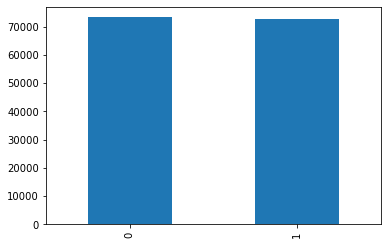

In [23]:
# label 값 분포 확인
train_data["label"].value_counts().plot(kind="bar");

In [24]:
# 레이블의 분포가 균일한지 확인
print(train_data.groupby('label').size().reset_index(name="count"))

   label  count
0      0  73342
1      1  72841


In [29]:
# Null 값 샘플 확인
train_data.isnull().sum()

id          0
document    1
label       0
dtype: int64

In [30]:
# Null 값이 어느 인덱스의 위치에 존재하는지 확인
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


In [31]:
# Null 값 샘플 제거
train_data = train_data.dropna(how='any')

In [32]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146182 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        146182 non-null  int64 
 1   document  146182 non-null  object
 2   label     146182 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.5+ MB
